In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from lib.utils import job_type_label, get_counts, plot_box_by_category, reg_score, leadership_label
from lib.utils import heatmap_by_category, alpha2_to_alpha3
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import smogn
from xgboost import XGBRegressor
from sklearn.ensemble import BaggingRegressor

In [2]:
cwd = Path.cwd()
source_data = Path(cwd)/"data"
preprocessed_data = cwd/'output/preprocessed_data'

# Exploratory Data Analysis

In [3]:
salaries = pd.read_csv(source_data/"salaries.csv")

In [4]:
salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16494 entries, 0 to 16493
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           16494 non-null  int64 
 1   experience_level    16494 non-null  object
 2   employment_type     16494 non-null  object
 3   job_title           16494 non-null  object
 4   salary              16494 non-null  int64 
 5   salary_currency     16494 non-null  object
 6   salary_in_usd       16494 non-null  int64 
 7   employee_residence  16494 non-null  object
 8   remote_ratio        16494 non-null  int64 
 9   company_location    16494 non-null  object
 10  company_size        16494 non-null  object
dtypes: int64(4), object(7)
memory usage: 1.4+ MB


In [5]:
salaries = salaries[['work_year', 'experience_level', 'employment_type', 'job_title', 'salary_currency',
                      'employee_residence', 'remote_ratio', 'company_location', 'company_size',
                      'salary_in_usd']]
salaries

work_year experience_level employment_type                 job_title  \
0           2024               MI              FT            Data Scientist   
1           2024               MI              FT            Data Scientist   
2           2024               MI              CT            Data Scientist   
3           2024               MI              CT            Data Scientist   
4           2024               MI              FT      Data Science Manager   
...          ...              ...             ...                       ...   
16489       2020               SE              FT            Data Scientist   
16490       2021               MI              FT  Principal Data Scientist   
16491       2020               EN              FT            Data Scientist   
16492       2020               EN              CT     Business Data Analyst   
16493       2021               SE              FT      Data Science Manager   

      salary_currency employee_residence  remote_ratio company_location  \
0                 USD                 AU             0               AU   
1                 USD                 AU             0               AU   
2                 USD                 US             0               US   
3                 USD                 US             0               US   
4                 USD                 US             0               US   
...               ...                ...           ...              ...   
16489             USD                 US           100               US   
16490             USD                 US           100               US   
16491             USD                 US           100               US   
16492             USD                 US           100               US   
16493             INR                 IN            50               IN   

      company_size  salary_in_usd  
0                S         120000  
1                S          70000  
2                M         130000  
3                M         110000  
4                M         240000  
...            ...            ...  
16489            L         412000  
16490            L         151000  
16491            S         105000  
16492            L         100000  
16493            L          94665  

[16494 rows x 10 columns]

In [6]:
cols = salaries.columns.values

for col in salaries.columns:
    print(f"{col} value counts:")
    print(salaries[col].value_counts(dropna=False))
    print("\n")


work_year value counts:
work_year
2023    8519
2024    6027
2022    1655
2021     218
2020      75
Name: count, dtype: int64


experience_level value counts:
experience_level
SE    10652
MI     4024
EN     1319
EX      499
Name: count, dtype: int64


employment_type value counts:
employment_type
FT    16414
PT       38
CT       28
FL       14
Name: count, dtype: int64


job_title value counts:
job_title
Data Engineer                3456
Data Scientist               3312
Data Analyst                 2428
Machine Learning Engineer    1703
Research Scientist            529
                             ... 
BI Data Engineer                1
Marketing Data Engineer         1
Data Science Tech Lead          1
Principal Data Architect        1
Cloud Data Architect            1
Name: count, Length: 155, dtype: int64


salary_currency value counts:
salary_currency
USD    15254
GBP      616
EUR      449
CAD       56
INR       55
AUD       12
CHF        8
PLN        7
SGD        6
BRL        5
DK

<Axes: >

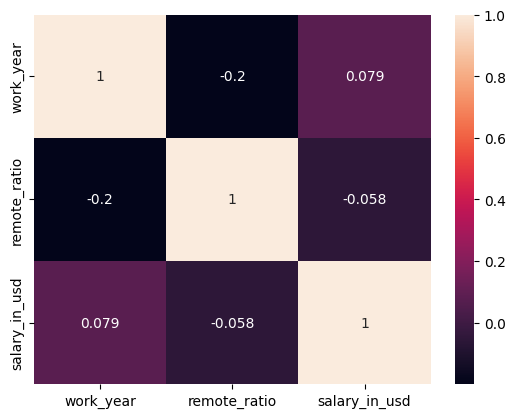

In [7]:
numeric_sal = salaries[['work_year', 'remote_ratio', 'salary_in_usd']]
sns.heatmap(numeric_sal.corr(), annot=True)

In [8]:
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=[
        "Top Job Titles", "Top Employee Residences",
    ]
)
cols = [
    ('job_title', None, 1, 1),
    ('employee_residence', None, 2, 1),
]
for col, order, row, column in cols:
    x, y = get_counts(salaries, col)
    fig.add_trace(go.Bar(x=x, y=y), row=row, col=column)

fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_yaxes(title_text="Count", row=2, col=1)

fig.update_layout(height=700, width=1000, showlegend=False)
fig.show()

In [9]:
count_jobexp = salaries.groupby(['job_title', 'experience_level']).size().reset_index(name='count')

fig = px.bar(
    count_jobexp,
    x='job_title',
    y='count',
    color='experience_level',
    barmode='stack',
    title='Count of Experience Levels per Job Title'
)
fig.update_layout(height=1000, width=1000, showlegend=True)
fig.show()

In [10]:
salaries2 = salaries.copy()
salaries2['work_year'] = salaries2['work_year'].astype(str)
salaries2['remote_ratio'] = salaries2['remote_ratio'].astype(str)

In [11]:
salaries2['job_type'] = salaries2['job_title'].apply(job_type_label)
print(salaries2['job_type'].unique())

['Data' 'BI' 'ML' 'Others' 'AI' 'Robotics']


In [12]:
country_codes = list(set(salaries['employee_residence'].tolist() + salaries['company_location'].tolist()))
len(country_codes)

90

In [13]:
country_to_continent = {
    'ES': 'Europe', 'SI': 'Europe', 'IQ': 'Asia', 'IL': 'Asia', 'HK': 'Asia',
    'NG': 'Africa', 'LV': 'Europe', 'AS': 'North America', 'BO': 'South America',
    'AE': 'Asia', 'GH': 'Africa', 'QA': 'Asia', 'AU': 'Oceania', 'SE': 'Europe',
    'RS': 'Europe', 'JP': 'Asia', 'DK': 'Europe', 'IT': 'Europe', 'PR': 'North America',
    'AM': 'Asia', 'TH': 'Asia', 'NL': 'Europe', 'PE': 'South America', 'BG': 'Europe',
    'HN': 'North America', 'NO': 'Europe', 'MX': 'North America', 'KW': 'Asia',
    'VN': 'Asia', 'SA': 'Asia', 'GI': 'Europe', 'PK': 'Asia', 'BR': 'South America',
    'AD': 'Europe', 'BA': 'Europe', 'UG': 'Africa', 'LB': 'Asia', 'LU': 'Europe',
    'GR': 'Europe', 'BS': 'North America', 'EC': 'South America', 'IN': 'Asia',
    'CN': 'Asia', 'CL': 'South America', 'DZ': 'Africa', 'RU': 'Europe', 'HU': 'Europe',
    'FR': 'Europe', 'UZ': 'Asia', 'EE': 'Europe', 'IR': 'Asia', 'AT': 'Europe',
    'ID': 'Asia', 'AR': 'South America', 'SG': 'Asia', 'DO': 'North America',
    'GB': 'Europe', 'CR': 'North America', 'UA': 'Europe', 'PH': 'Asia', 'BE': 'Europe',
    'LT': 'Europe', 'NZ': 'Oceania', 'EG': 'Africa', 'CA': 'North America', 'IE': 'Europe',
    'OM': 'Asia', 'MY': 'Asia', 'KR': 'Asia', 'KE': 'Africa', 'TR': 'Asia',
    'GE': 'Asia', 'DE': 'Europe', 'CY': 'Europe', 'ZA': 'Africa', 'CH': 'Europe',
    'MT': 'Europe', 'MD': 'Europe', 'MU': 'Africa', 'US': 'North America',
    'HR': 'Europe', 'FI': 'Europe', 'CF': 'Africa', 'RO': 'Europe', 'CO': 'South America',
    'TN': 'Africa', 'JE': 'Europe', 'PL': 'Europe', 'CZ': 'Europe', 'PT': 'Europe'
}
salaries2['employee_continent'] = salaries2['employee_residence'].map(country_to_continent)
salaries2['company_continent'] = salaries2['company_location'].map(country_to_continent)

In [14]:
job_type_order = ['Data', 'BI', 'ML', 'AI', 'Robotics', 'Others']
work_year_order = ['2020', '2021', '2022', '2023', '2024']
remote_ratio_order = ['0', '50', '100']
experience_level_order = ['EN', 'MI', 'SE', 'EX']
company_size_order = ['S', 'M', 'L']

fig = make_subplots(
    rows=4, cols=2,
    subplot_titles=[
        "Experience Level", "Employment Type",
        "Job Type", "Employee Continent",
        "Company Continent", "Company Size",
        "Work Year", "Remote Ratio"
    ]
)
cols = [
    ('experience_level', experience_level_order, 1, 1),
    ('employment_type', None, 1, 2),
    ('job_type', job_type_order, 2, 1),
    ('employee_continent', None, 2, 2),
    ('company_continent', None, 3, 1),
    ('company_size', company_size_order, 3, 2),
    ('work_year', work_year_order, 4, 1),
    ('remote_ratio', remote_ratio_order, 4, 2)
]
for col, order, row, column in cols:
    x, y = get_counts(salaries2, col, order)
    fig.add_trace(go.Bar(x=x, y=y), row=row, col=column)

fig.update_layout(height=700, width=1000, showlegend=False)
fig.show()


In [15]:
fig = px.histogram(salaries2, x='salary_in_usd', nbins=30, title='Salary Distribution (USD)')
fig.show()

In [16]:
job_type_colors = {
    'Data': 'indianred',
    'ML': 'lightseagreen',
    'AI': '#8da0cb',
    'BI': '#e78ac3',
    'Robotics': '#a6d854',
    'Others': '#ffd92f'
}

experience_colors = {
    'EN': '#636EFA',
    'MI': '#EF553B',
    'SE': '#00CC96',
    'EX': '#AB63FA'
}

company_size_colors = {
    'S': '#ffd92f',
    'M': '#e78ac3',
    'L': '#a6d854',
}

company_location_colors = {
    'North America': '#5DADE2',
    'Europe': '#F39C12',
    'Asia': '#27AE60',
    'Oceania': '#AF7AC5',
    'Africa': '#D35400',
    'South America': '#566573'
}

remote_ratio_colors = {
    '0': '#27AE60',
    '50': '#5DADE2',
    '100': '#ffd92f',
}

work_year_colors = {
    '2020': '#566573',
    '2021': '#F39C12',
    '2022': '#00CC96',
    '2023': "#030303",
    '2024': '#EF553B',

}

In [17]:
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=["Salary by Job Type", "Salary by Experience Level",
                    "Salary by Company Size", "Salary by Company Continent",
                    "Salary by Remote Ratio", "Salary by Work Year"]
)

# Add job_type boxplots to first column, experience_level boxplots to second
plot_box_by_category(fig, salaries2, 'job_type', 'salary_in_usd', job_type_colors, 1, 1)
plot_box_by_category(fig, salaries2, 'experience_level', 'salary_in_usd', experience_colors, 1, 2)
plot_box_by_category(fig, salaries2, 'company_size', 'salary_in_usd', company_size_colors, 2, 1)
plot_box_by_category(fig, salaries2, 'company_continent', 'salary_in_usd', company_location_colors, 2, 2)
plot_box_by_category(fig, salaries2, 'remote_ratio', 'salary_in_usd', remote_ratio_colors, 3, 1)
plot_box_by_category(fig, salaries2, 'work_year', 'salary_in_usd', work_year_colors, 3, 2)

fig.update_layout(
    height=1000,
    width=1000,
    showlegend=False,
    title_text="Salaries Distribution by Category"
)
fig.show()

In [18]:
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=["Median Salaries by Job Experience and Remote Work",
                    "Median Salaries by Employee Continent and Job Type"]
)

trace1 = heatmap_by_category(salaries2, 'experience_level', 'remote_ratio', 'salary_in_usd',
                             'Viridis', 'Median Salary [USD]',
                             1, 0.82, remote_ratio_order, experience_level_order)

fig.add_trace(trace1, row=1, col=1)

trace2 = heatmap_by_category(salaries2, 'employee_continent', 'job_type', 'salary_in_usd',
                             'Magma', 'Median Salary [USD]',
                             1, 0.19, job_type_order)

fig.add_trace(trace2, row=2, col=1)

fig.update_layout(
    height=800,
    width=800,
    showlegend=False,
    title_text="Median Salaries Heatmap by Categories"
)
fig.show()

In [19]:
# Programmatic Outlier Detection using IQR method
Q1 = salaries2['salary_in_usd'].quantile(0.25)
Q3 = salaries2['salary_in_usd'].quantile(0.75)
IQR = Q3 - Q1

# Calculate bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"IQR Analysis:")
print(f"Q1 (25th percentile): ${Q1:,.2f}")
print(f"Q3 (75th percentile): ${Q3:,.2f}")
print(f"IQR: ${IQR:,.2f}")
print(f"Lower bound: ${lower_bound:,.2f}")
print(f"Upper bound: ${upper_bound:,.2f}")

# Identify outliers
outliers = salaries2[(salaries2['salary_in_usd'] < lower_bound) | (salaries2['salary_in_usd'] > upper_bound)]

# Quantify outliers
total_records = len(salaries2)
outlier_count = len(outliers)
outlier_percentage = (outlier_count / total_records) * 100

print(f"\n=== Outlier Quantification ===")
print(f"Total records: {total_records:,}")
print(f"Outlier records: {outlier_count:,}")
print(f"Outlier percentage: {outlier_percentage:.2f}%")

IQR Analysis:
Q1 (25th percentile): $101,517.50
Q3 (75th percentile): $185,900.00
IQR: $84,382.50
Lower bound: $-25,056.25
Upper bound: $312,473.75

=== Outlier Quantification ===
Total records: 16,494
Outlier records: 284
Outlier percentage: 1.72%


In [20]:
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=[
        "Top Paid Jobs by Experience Level", "Top Paid Jobs by Job Title",
    ]
)
cols = [
    ('experience_level', None, 1, 1),
    ('job_title', None, 2, 1),
]
for col, order, row, column in cols:
    x, y = get_counts(outliers, col)
    fig.add_trace(go.Bar(x=x, y=y), row=row, col=column)

fig.update_yaxes(title_text="Count", row=1, col=1)
fig.update_yaxes(title_text="Count", row=2, col=1)

fig.update_layout(height=700, width=1000, showlegend=False)
fig.show()

# Features Importance and Features Engineering

## Existing Features

In [21]:
salaries2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16494 entries, 0 to 16493
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           16494 non-null  object
 1   experience_level    16494 non-null  object
 2   employment_type     16494 non-null  object
 3   job_title           16494 non-null  object
 4   salary_currency     16494 non-null  object
 5   employee_residence  16494 non-null  object
 6   remote_ratio        16494 non-null  object
 7   company_location    16494 non-null  object
 8   company_size        16494 non-null  object
 9   salary_in_usd       16494 non-null  int64 
 10  job_type            16494 non-null  object
 11  employee_continent  16494 non-null  object
 12  company_continent   16494 non-null  object
dtypes: int64(1), object(12)
memory usage: 1.6+ MB


In [22]:
salaries3 = salaries2.drop(['job_title', 'employee_residence', 'company_location'], axis=1)
salaries3 = salaries3[['experience_level', 'company_size', 'work_year', 'remote_ratio', 'salary_currency',
                       'employment_type', 'job_type', 'employee_continent', 'company_continent',
                       'salary_in_usd']]
salaries3

experience_level company_size work_year remote_ratio salary_currency  \
0                   MI            S      2024            0             USD   
1                   MI            S      2024            0             USD   
2                   MI            M      2024            0             USD   
3                   MI            M      2024            0             USD   
4                   MI            M      2024            0             USD   
...                ...          ...       ...          ...             ...   
16489               SE            L      2020          100             USD   
16490               MI            L      2021          100             USD   
16491               EN            S      2020          100             USD   
16492               EN            L      2020          100             USD   
16493               SE            L      2021           50             INR   

      employment_type job_type employee_continent company_continent  \
0                  FT     Data            Oceania           Oceania   
1                  FT     Data            Oceania           Oceania   
2                  CT     Data      North America     North America   
3                  CT     Data      North America     North America   
4                  FT     Data      North America     North America   
...               ...      ...                ...               ...   
16489              FT     Data      North America     North America   
16490              FT     Data      North America     North America   
16491              FT     Data      North America     North America   
16492              CT     Data      North America     North America   
16493              FT     Data               Asia              Asia   

       salary_in_usd  
0             120000  
1              70000  
2             130000  
3             110000  
4             240000  
...              ...  
16489         412000  
16490         151000  
16491         105000  
16492         100000  
16493          94665  

[16494 rows x 10 columns]

In [23]:
rf_reg = RandomForestRegressor()
ordinal_cols = [0,1,2,3]
nominal_cols = [4,5,6,7,8]
feature_names = salaries3.columns[:-1]
X = salaries3.iloc[:, :-1].values
y = salaries3.iloc[:, -1].values
ct = ColumnTransformer(transformers=[('ord', OrdinalEncoder(), ordinal_cols),
                                     ('nom', OneHotEncoder(sparse_output=False), nominal_cols)],
                                     remainder="passthrough")
X = np.array(ct.fit_transform(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
reg_score(rf_reg, X_train, y_train, X_test, y_test)
feature_names_out = ct.get_feature_names_out(feature_names)
importances = rf_reg.feature_importances_
importances_series = pd.Series(importances, index=feature_names_out).sort_values(ascending=False)
print(importances_series)

R^2 Score: 0.277
RMSE: 59,314.39
MSE: 3,518,196,991.02
MAE: 42,829.30
ord__experience_level                    0.281191
nom__salary_currency_USD                 0.253559
nom__job_type_Data                       0.118373
nom__employee_continent_North America    0.083766
nom__job_type_BI                         0.068390
ord__work_year                           0.041073
ord__remote_ratio                        0.030316
ord__company_size                        0.021808
nom__job_type_ML                         0.020835
nom__job_type_Others                     0.017227
nom__employee_continent_Asia             0.006372
nom__employee_continent_South America    0.006042
nom__job_type_AI                         0.005868
nom__salary_currency_ILS                 0.005446
nom__employment_type_FT                  0.004069
nom__salary_currency_GBP                 0.003536
nom__company_continent_North America     0.003155
nom__company_continent_Europe            0.002905
nom__employee_continent_Europe

## New Features

### Features Interaction

In [24]:
salaries4 = salaries3.copy()
salaries4['job_level'] = salaries2['job_title'].apply(leadership_label)
salaries4['exp_level_job'] = salaries4['experience_level'] + '_' + salaries4['job_type']
salaries4['exp_level_econtinent'] = salaries4['experience_level'] + '_' + salaries4['employee_continent']
salaries4['job_level_exp'] = salaries4['job_level'] + '_' + salaries4['experience_level']
salaries4['work_year_econtinent'] = salaries4['work_year'] + '_' + salaries4['employee_continent']
job_title_freq = salaries2['job_title'].value_counts().to_dict()
salaries4['job_title_popularity'] = salaries2['job_title'].map(job_title_freq)
salaries4['same_continent'] = (salaries4['employee_continent'] == salaries4['company_continent']).astype(int)
salaries4['log_salaries'] = np.log1p(salaries4['salary_in_usd'])
salaries4 = salaries4.drop(['salary_in_usd'], axis=1)
salaries4

experience_level company_size work_year remote_ratio salary_currency  \
0                   MI            S      2024            0             USD   
1                   MI            S      2024            0             USD   
2                   MI            M      2024            0             USD   
3                   MI            M      2024            0             USD   
4                   MI            M      2024            0             USD   
...                ...          ...       ...          ...             ...   
16489               SE            L      2020          100             USD   
16490               MI            L      2021          100             USD   
16491               EN            S      2020          100             USD   
16492               EN            L      2020          100             USD   
16493               SE            L      2021           50             INR   

      employment_type job_type employee_continent company_continent job_level  \
0                  FT     Data            Oceania           Oceania     Staff   
1                  FT     Data            Oceania           Oceania     Staff   
2                  CT     Data      North America     North America     Staff   
3                  CT     Data      North America     North America     Staff   
4                  FT     Data      North America     North America   Manager   
...               ...      ...                ...               ...       ...   
16489              FT     Data      North America     North America     Staff   
16490              FT     Data      North America     North America     Staff   
16491              FT     Data      North America     North America     Staff   
16492              CT     Data      North America     North America     Staff   
16493              FT     Data               Asia              Asia   Manager   

      exp_level_job exp_level_econtinent job_level_exp work_year_econtinent  \
0           MI_Data           MI_Oceania      Staff_MI         2024_Oceania   
1           MI_Data           MI_Oceania      Staff_MI         2024_Oceania   
2           MI_Data     MI_North America      Staff_MI   2024_North America   
3           MI_Data     MI_North America      Staff_MI   2024_North America   
4           MI_Data     MI_North America    Manager_MI   2024_North America   
...             ...                  ...           ...                  ...   
16489       SE_Data     SE_North America      Staff_SE   2020_North America   
16490       MI_Data     MI_North America      Staff_MI   2021_North America   
16491       EN_Data     EN_North America      Staff_EN   2020_North America   
16492       EN_Data     EN_North America      Staff_EN   2020_North America   
16493       SE_Data              SE_Asia    Manager_SE            2021_Asia   

       job_title_popularity  same_continent  log_salaries  
0                      3312               1     11.695255  
1                      3312               1     11.156265  
2                      3312               1     11.775297  
3                      3312               1     11.608245  
4                       122               1     12.388398  
...                     ...             ...           ...  
16489                  3312               1     12.928781  
16490                    10               1     11.925042  
16491                  3312               1     11.561725  
16492                    21               1     11.512935  
16493                   122               1     11.458110  

[16494 rows x 17 columns]

In [25]:
fig = px.histogram(salaries4, x='log_salaries', nbins=30, title='Log Salary Distribution')
fig.show()

In [26]:
ordinal_cols = [0,1,2,3]
nominal_cols = [4,5,6,7,8,9,10,11,12,13]
feature_names_in = salaries4.columns[:-1]
X = salaries4.iloc[:, :-1].values
y = salaries4.iloc[:, -1].values
ct = ColumnTransformer(transformers=[('ord', OrdinalEncoder(), ordinal_cols),
                                     ('nom', OneHotEncoder(sparse_output=False), nominal_cols)],
                                     remainder="passthrough")
sc = StandardScaler()
X = ct.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
reg_score(rf_reg, X_train, y_train, X_test, y_test)
feature_names_out = ct.get_feature_names_out(feature_names_in)
importances = rf_reg.feature_importances_
importances_series = pd.Series(importances, index=feature_names_out).sort_values(ascending=False)
print(importances_series)

R^2 Score: 0.452
RMSE: 0.36
MSE: 0.13
MAE: 0.28
nom__employee_continent_North America    2.742772e-01
remainder__job_title_popularity          1.415145e-01
nom__salary_currency_USD                 9.489368e-02
ord__experience_level                    7.021117e-02
nom__exp_level_job_MI_Data               5.720034e-02
                                             ...     
nom__salary_currency_NOK                 1.587274e-06
nom__salary_currency_NZD                 8.397455e-09
nom__salary_currency_MXN                 0.000000e+00
nom__salary_currency_PHP                 0.000000e+00
nom__salary_currency_ZAR                 0.000000e+00
Length: 139, dtype: float64


### New Grouping based on Employee Residence and Job Title Using KNN

In [27]:
from sklearn.cluster import KMeans

X_kmeans = salaries2[['employee_residence', 'job_title']]
y_kmeans = salaries4['log_salaries']
ct = ColumnTransformer(transformers=[('nom', OneHotEncoder(sparse_output=False), [0,1])],
                                     remainder="passthrough")
X_kmeans = ct.fit_transform(X_kmeans)
n_groups = 10
kmeans = KMeans(n_clusters=n_groups, random_state=42, n_init=10)
group_labels = kmeans.fit_predict(X_kmeans)
salaries5 = salaries4.copy()
salaries5['kmeans_group'] = group_labels.astype(str)
salaries5['employee_residence'] = salaries2['employee_residence']

In [28]:
salaries5['iso_alpha'] = salaries5['employee_residence'].apply(alpha2_to_alpha3)
# fig_geo = px.choropleth(
#     salaries5, locations="iso_alpha",
#     color="employee_continent",
#     title="Countries Grouped by Continent"
# )
# fig_geo.show()

In [29]:
# fig_kmeans = px.choropleth(
#     salaries5, locations="iso_alpha",
#     color="kmeans_group",
#     title="Countries Grouped by KMeans Clusters"
# )
# fig_kmeans.show()

### Combining with GDP

In [30]:
gdp = pd.read_csv(source_data/'gdp.csv', skiprows=4, skip_blank_lines=True)
gdp = gdp.iloc[:, :-1]
gdp.dropna()
gdp = gdp.drop(['Indicator Name', 'Indicator Code'], axis=1)
gdp = pd.melt(
    gdp,
    id_vars=["Country Name", "Country Code"],     # columns to keep fixed
    var_name="Year",              # new column for former wide column names
    value_name="GDP_USD"          # new column for values
)

In [31]:
gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17290 entries, 0 to 17289
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  17290 non-null  object 
 1   Country Code  17290 non-null  object 
 2   Year          17290 non-null  object 
 3   GDP_USD       14541 non-null  float64
dtypes: float64(1), object(3)
memory usage: 540.4+ KB


In [32]:
years_to_keep = ['2020', '2021', '2022', '2023', '2024']

gdp = gdp[gdp['Year'].isin(years_to_keep)]
gdp

Country Name Country Code  Year       GDP_USD
15960                        Aruba          ABW  2020  2.481857e+09
15961  Africa Eastern and Southern          AFE  2020  9.334072e+11
15962                  Afghanistan          AFG  2020  1.995593e+10
15963   Africa Western and Central          AFW  2020  7.972952e+11
15964                       Angola          AGO  2020  4.850156e+10
...                            ...          ...   ...           ...
17285                       Kosovo          XKX  2024  1.114860e+10
17286                  Yemen, Rep.          YEM  2024           NaN
17287                 South Africa          ZAF  2024  4.002607e+11
17288                       Zambia          ZMB  2024  2.632578e+10
17289                     Zimbabwe          ZWE  2024  4.418770e+10

[1330 rows x 4 columns]

In [38]:
salaries6 = pd.merge(
    salaries5,
    gdp[['Country Code', 'Year', 'GDP_USD']],
    how='left',
    left_on=['iso_alpha', 'work_year'],
    right_on=['Country Code', 'Year']
)
salaries6

experience_level company_size work_year remote_ratio salary_currency  \
0                   MI            S      2024            0             USD   
1                   MI            S      2024            0             USD   
2                   MI            M      2024            0             USD   
3                   MI            M      2024            0             USD   
4                   MI            M      2024            0             USD   
...                ...          ...       ...          ...             ...   
16489               SE            L      2020          100             USD   
16490               MI            L      2021          100             USD   
16491               EN            S      2020          100             USD   
16492               EN            L      2020          100             USD   
16493               SE            L      2021           50             INR   

      employment_type job_type employee_continent company_continent job_level  \
0                  FT     Data            Oceania           Oceania     Staff   
1                  FT     Data            Oceania           Oceania     Staff   
2                  CT     Data      North America     North America     Staff   
3                  CT     Data      North America     North America     Staff   
4                  FT     Data      North America     North America   Manager   
...               ...      ...                ...               ...       ...   
16489              FT     Data      North America     North America     Staff   
16490              FT     Data      North America     North America     Staff   
16491              FT     Data      North America     North America     Staff   
16492              CT     Data      North America     North America     Staff   
16493              FT     Data               Asia              Asia   Manager   

       ... work_year_econtinent job_title_popularity same_continent  \
0      ...         2024_Oceania                 3312              1   
1      ...         2024_Oceania                 3312              1   
2      ...   2024_North America                 3312              1   
3      ...   2024_North America                 3312              1   
4      ...   2024_North America                  122              1   
...    ...                  ...                  ...            ...   
16489  ...   2020_North America                 3312              1   
16490  ...   2021_North America                   10              1   
16491  ...   2020_North America                 3312              1   
16492  ...   2020_North America                   21              1   
16493  ...            2021_Asia                  122              1   

      log_salaries  kmeans_group  employee_residence  iso_alpha Country Code  \
0        11.695255             3                  AU        AUS          AUS   
1        11.156265             3                  AU        AUS          AUS   
2        11.775297             3                  US        USA          USA   
3        11.608245             3                  US        USA          USA   
4        12.388398             8                  US        USA          USA   
...            ...           ...                 ...        ...          ...   
16489    12.928781             3                  US        USA          USA   
16490    11.925042             8                  US        USA          USA   
16491    11.561725             3                  US        USA          USA   
16492    11.512935             8                  US        USA          USA   
16493    11.458110             9                  IN        IND          IND   

       Year       GDP_USD  
0      2024  1.752193e+12  
1      2024  1.752193e+12  
2      2024  2.918489e+13  
3      2024  2.918489e+13  
4      2024  2.918489e+13  
...     ...           ...  
16489  2020  2.135410e+13  
16490  2021  2.368117e+13  
16491  2020  2.135410e+13  
16

In [42]:
missing_gdp = salaries6[salaries6['GDP_USD'].isna()]
print(missing_gdp[['work_year','iso_alpha','Year','GDP_USD']].head())

      work_year iso_alpha  Year  GDP_USD
5518       2024       LBN  2024      NaN
5519       2024       LBN  2024      NaN
16369      2021       JEY   NaN      NaN


In [43]:
salaries6.loc[[5518, 5519], 'GDP_USD'] = 28280000000
salaries6.loc[16369, 'GDP_USD'] = 7013000000
missing_gdp = salaries6[salaries6['GDP_USD'].isna()]
print(missing_gdp[['work_year','iso_alpha','Year','GDP_USD']].head())

Empty DataFrame
Columns: [work_year, iso_alpha, Year, GDP_USD]
Index: []


In [44]:
salaries7 = salaries6.drop(['employee_residence', 'iso_alpha', 'Country Code', 'Year'], axis=1)
salaries7 = salaries7[['experience_level', 'company_size', 'work_year', 'remote_ratio',
       'salary_currency', 'employment_type', 'job_type', 'employee_continent',
       'company_continent', 'job_level', 'exp_level_job',
       'exp_level_econtinent', 'job_level_exp', 'work_year_econtinent', 'kmeans_group',
       'job_title_popularity', 'same_continent', 'GDP_USD', 'log_salaries'
       ]]
salaries7

experience_level company_size work_year remote_ratio salary_currency  \
0                   MI            S      2024            0             USD   
1                   MI            S      2024            0             USD   
2                   MI            M      2024            0             USD   
3                   MI            M      2024            0             USD   
4                   MI            M      2024            0             USD   
...                ...          ...       ...          ...             ...   
16489               SE            L      2020          100             USD   
16490               MI            L      2021          100             USD   
16491               EN            S      2020          100             USD   
16492               EN            L      2020          100             USD   
16493               SE            L      2021           50             INR   

      employment_type job_type employee_continent company_continent job_level  \
0                  FT     Data            Oceania           Oceania     Staff   
1                  FT     Data            Oceania           Oceania     Staff   
2                  CT     Data      North America     North America     Staff   
3                  CT     Data      North America     North America     Staff   
4                  FT     Data      North America     North America   Manager   
...               ...      ...                ...               ...       ...   
16489              FT     Data      North America     North America     Staff   
16490              FT     Data      North America     North America     Staff   
16491              FT     Data      North America     North America     Staff   
16492              CT     Data      North America     North America     Staff   
16493              FT     Data               Asia              Asia   Manager   

      exp_level_job exp_level_econtinent job_level_exp work_year_econtinent  \
0           MI_Data           MI_Oceania      Staff_MI         2024_Oceania   
1           MI_Data           MI_Oceania      Staff_MI         2024_Oceania   
2           MI_Data     MI_North America      Staff_MI   2024_North America   
3           MI_Data     MI_North America      Staff_MI   2024_North America   
4           MI_Data     MI_North America    Manager_MI   2024_North America   
...             ...                  ...           ...                  ...   
16489       SE_Data     SE_North America      Staff_SE   2020_North America   
16490       MI_Data     MI_North America      Staff_MI   2021_North America   
16491       EN_Data     EN_North America      Staff_EN   2020_North America   
16492       EN_Data     EN_North America      Staff_EN   2020_North America   
16493       SE_Data              SE_Asia    Manager_SE            2021_Asia   

      kmeans_group  job_title_popularity  same_continent       GDP_USD  \
0                3                  3312               1  1.752193e+12   
1                3                  3312               1  1.752193e+12   
2                3                  3312               1  2.918489e+13   
3                3                  3312               1  2.918489e+13   
4                8                   122               1  2.918489e+13   
...            ...                   ...             ...           ...   
16489            3                  3312               1  2.135410e+13   
16490            8                    10               1  2.368117e+13   
16491            3                  3312               1  2.135410e+13   
16492            8                    21               1  2.135410e+13   
16493            9                   122               1  3.167271e+12   

       log_salaries  
0         11.695255  
1         11.156265  
2         11.775297  
3         11.608245  
4         12.388398  
...             ...  
16489     12.928781  
16490     11.925042  
16491     11.561725  
16492     11.512935  
16493     11.458

In [46]:
ordinal_cols = [0,1,2,3]
nominal_cols = [4,5,6,7,8,9,10,11,12,13,14]
feature_names_in = salaries7.columns[:-1]
X = salaries7.iloc[:, :-1].values
y = salaries7.iloc[:, -1].values
ct = ColumnTransformer(transformers=[('ord', OrdinalEncoder(), ordinal_cols),
                                     ('nom', OneHotEncoder(sparse_output=False), nominal_cols)],
                                     remainder="passthrough")
sc = StandardScaler()
X = ct.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
reg_score(rf_reg, X_train, y_train, X_test, y_test)
feature_names_out = ct.get_feature_names_out(feature_names_in)
importances = rf_reg.feature_importances_
importances_series = pd.Series(importances, index=feature_names_out).sort_values(ascending=False)
print(importances_series)

R^2 Score: 0.455
RMSE: 0.36
MSE: 0.13
MAE: 0.28
nom__employee_continent_North America     0.266423
nom__kmeans_group_4                       0.103191
nom__salary_currency_USD                  0.097401
remainder__job_title_popularity           0.081245
ord__experience_level                     0.058773
                                            ...   
nom__work_year_econtinent_2020_Oceania    0.000002
nom__salary_currency_NZD                  0.000001
nom__salary_currency_MXN                  0.000000
nom__salary_currency_PHP                  0.000000
nom__salary_currency_ZAR                  0.000000
Length: 150, dtype: float64


In [47]:
base_reg = XGBRegressor()
bag_reg = BaggingRegressor(
    estimator=base_reg,
    n_estimators=10,
    random_state=42,
    bootstrap=True,
    n_jobs=-1
)
reg_score(bag_reg, X_train, y_train, X_test, y_test)

R^2 Score: 0.471
RMSE: 0.36
MSE: 0.13
MAE: 0.28


In [48]:
salaries7.to_parquet(preprocessed_data/'preprocessed_data.parquet', index=False)